# Bagging and Random Forest

#### 1) Data Import and Cleaning

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearnex import patch_sklearn
patch_sklearn(verbose=False)

ModuleNotFoundError: No module named 'sklearnex'

In [3]:
heart = pd.read_csv('Heart_ISL.csv', sep = ",")
heart = heart.dropna().reset_index(drop = True)
heart = heart.astype({'ChestPain':'category', 'Thal':'category', 'AHD':'category'})
print("Dataset shape:", heart.shape)

# Read in the data, csv
#  .dropna():Rmove any rows with missing data
#   .reset_index(drop=True): Reset the index of the resulting DataFrame after the rows with missing data are dropped
#    .astype(): Convert the data types of some of the columns to category

heart.head() # Display the first # of rows of the DataFrame

Dataset shape: (297, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
heart.info() # Prints concise summary of a DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  297 non-null    int64   
 1   Age         297 non-null    int64   
 2   Sex         297 non-null    int64   
 3   ChestPain   297 non-null    category
 4   RestBP      297 non-null    int64   
 5   Chol        297 non-null    int64   
 6   Fbs         297 non-null    int64   
 7   RestECG     297 non-null    int64   
 8   MaxHR       297 non-null    int64   
 9   ExAng       297 non-null    int64   
 10  Oldpeak     297 non-null    float64 
 11  Slope       297 non-null    int64   
 12  Ca          297 non-null    float64 
 13  Thal        297 non-null    category
 14  AHD         297 non-null    category
dtypes: category(3), float64(2), int64(10)
memory usage: 29.3 KB


In [5]:
# Extra code, removal of duplicates
print(heart.ChestPain.drop_duplicates()) # typical, asymptomatic, nonanginal, nontypical
print(heart.Thal.drop_duplicates()) # fixed, normal, reversable
print(heart.AHD.drop_duplicates()) # No, Yes

0         typical
1    asymptomatic
3      nonanginal
4      nontypical
Name: ChestPain, dtype: category
Categories (4, object): ['asymptomatic', 'nonanginal', 'nontypical', 'typical']
0         fixed
1        normal
2    reversable
Name: Thal, dtype: category
Categories (3, object): ['fixed', 'normal', 'reversable']
0     No
1    Yes
Name: AHD, dtype: category
Categories (2, object): ['No', 'Yes']


In [6]:
# Missing data
print("Missing values distribution: ")
print(heart.isnull().mean()) # Displays the proportion of missing values in each column of heart. The index of the Series will be the column names of heart, and the values will be between 0 and 1
print("")

Missing values distribution: 
Unnamed: 0    0.0
Age           0.0
Sex           0.0
ChestPain     0.0
RestBP        0.0
Chol          0.0
Fbs           0.0
RestECG       0.0
MaxHR         0.0
ExAng         0.0
Oldpeak       0.0
Slope         0.0
Ca            0.0
Thal          0.0
AHD           0.0
dtype: float64



In [7]:
# Removing leading and trailing characters from columns with str type(!)
#str_cols = list(heart.columns)

#for i in str_cols:
#    heart[i] = heart[i].str.strip()

In [8]:
heart.describe() # Computes summary statistics for DataFrame

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,150.673401,54.542088,0.676768,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768
std,87.323283,9.049736,0.468500,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,75.000000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,150.000000,56.000000,1.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,226.000000,61.000000,1.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,302.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [9]:
X = heart.drop(["AHD"], axis = 1)
X = pd.get_dummies(X, drop_first = True) # n - 1 variables
X = pd.get_dummies(heart.drop("AHD", axis = 1), drop_first = True) # Remove the response from the other predictor variables
# get_dummies: Converts categorical variables into dummy/indicator variables
#  drop_first = True: Drops the first category of each categorical variable to avoid creating a "dummy variable trap".

y = heart["AHD"] # Keep 1 bracket for RF, [] gives you a vector, and [[]] gives a data frame
# Only keep the response variable

X.shape # 297 and 14 ... Dimensions of Panda/NumPy type objects
y.shape # 297 and ___ ... Dimensions of Panda/NumPy type objects

(297,)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
# X and y are the input features (predictors) and target (response) variable separately
#  test_size parameter is the porprotion of the data allocated in the test set
#   random_state parameter initializes the random number generator to produce the same results each run

#### 2.0) Bagging and Random Forests

In [11]:
from sklearn.ensemble import RandomForestClassifier # RandomForestRegressor
from sklearn.tree import plot_tree

In [12]:
# Instantiate model with 200 decision trees
RF = RandomForestClassifier(n_estimators = 200, max_features = "sqrt", random_state = 1) # sqrt is the default
# n_estimators: Number of trees in the forest.
# max_features: Maximum number of features to consider when splitting a node.
# random_state: Seed used by the random number generator. This ensures that the randomization used by the algorithm is reproducible.

In [13]:
RF.fit(X, y) # Trains the model on the input data and computes the decision boundary that separates different classes in the data

RandomForestClassifier(n_estimators=200, random_state=1)

In [14]:
RF.estimators_ # Returns a list of decision tree objects, where each tree is trained on a random subset of the input features and a random subset of the training data.

[DecisionTreeClassifier(max_features='sqrt', random_state=1791095845),
 DecisionTreeClassifier(max_features='sqrt', random_state=2135392491),
 DecisionTreeClassifier(max_features='sqrt', random_state=946286476),
 DecisionTreeClassifier(max_features='sqrt', random_state=1857819720),
 DecisionTreeClassifier(max_features='sqrt', random_state=491263),
 DecisionTreeClassifier(max_features='sqrt', random_state=550290313),
 DecisionTreeClassifier(max_features='sqrt', random_state=1298508491),
 DecisionTreeClassifier(max_features='sqrt', random_state=2143362693),
 DecisionTreeClassifier(max_features='sqrt', random_state=630311759),
 DecisionTreeClassifier(max_features='sqrt', random_state=1013994432),
 DecisionTreeClassifier(max_features='sqrt', random_state=396591248),
 DecisionTreeClassifier(max_features='sqrt', random_state=1703301249),
 DecisionTreeClassifier(max_features='sqrt', random_state=799981516),
 DecisionTreeClassifier(max_features='sqrt', random_state=1666063943),
 DecisionTreeCl

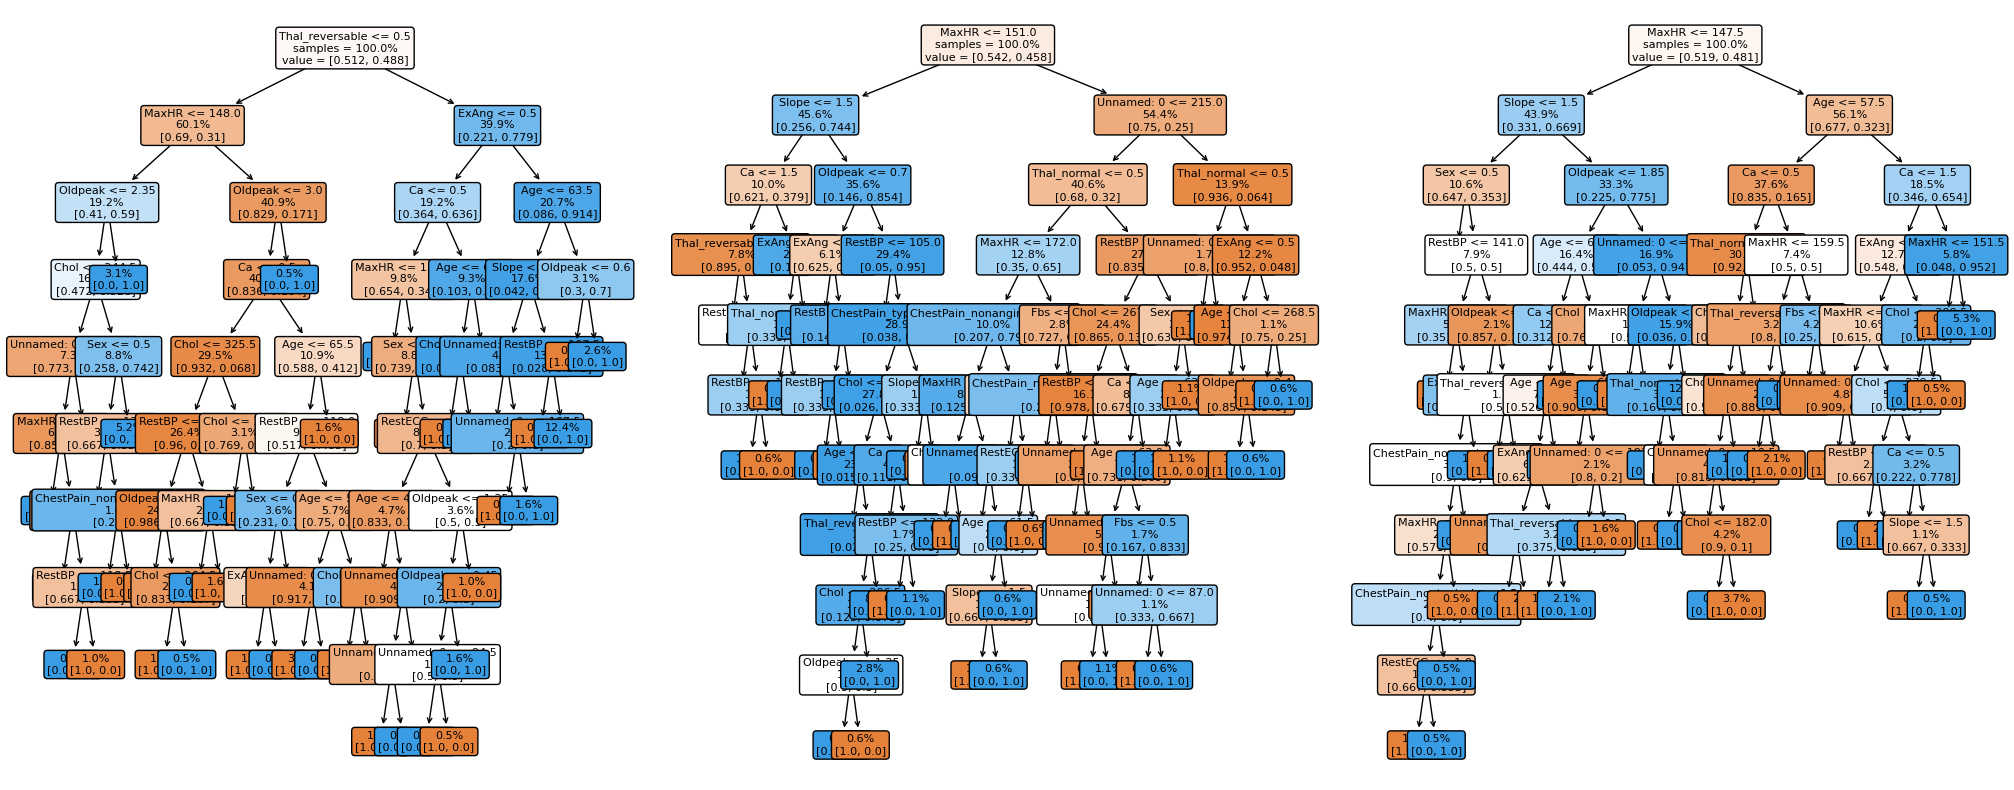

In [15]:
fig, axs = plt.subplots(1,3,figsize = (25, 10)) # Sets the size of the figure in inches
# The resulting figure is stored in the fig variable, and the three subplots are stored in the axs variable

# enumerate: Used to iterate over the first three estimators of the Random Forest model, and for each estimator
for i, RF in enumerate(RF.estimators_[0:3]):
    plot_tree(RF, feature_names = X_train.columns.tolist(), impurity = False, label = "root",
          filled = True, proportion = True, rounded = True, fontsize = 8, ax = axs[i])
# feature_names=X_train.columns.tolist(): Provides the names of the features (i.e., the independent variables) to use as labels for the nodes in the decision tree.
#  impurity = False: Specifies that we don't want to show the impurity (i.e., entropy or Gini index) for each node in the tree.
#   label = "root": Specifies that the root node should be labeled as "root".
#    filled = True: Specifies that we want to color the nodes in the tree based on the majority class of the training samples that fall within them.
#     proportion = True: Specifies that we want to show the proportion of training samples in each node that belong to each class.
#      rounded = True: Specifies that we want to round the corners of the boxes that represent nodes in the tree.
#       fontsize = 8: Specifies the font size to use for the text in the plot.
#        axs[i]: Plot each tree in a different subplot in the figure (axs).
plt.show() # Displays the plot of the decision tree.

In [16]:
np.sqrt(X_train.shape[1]) # Calculates the square root of the number of features in the training data, second element in the tuple

4.123105625617661

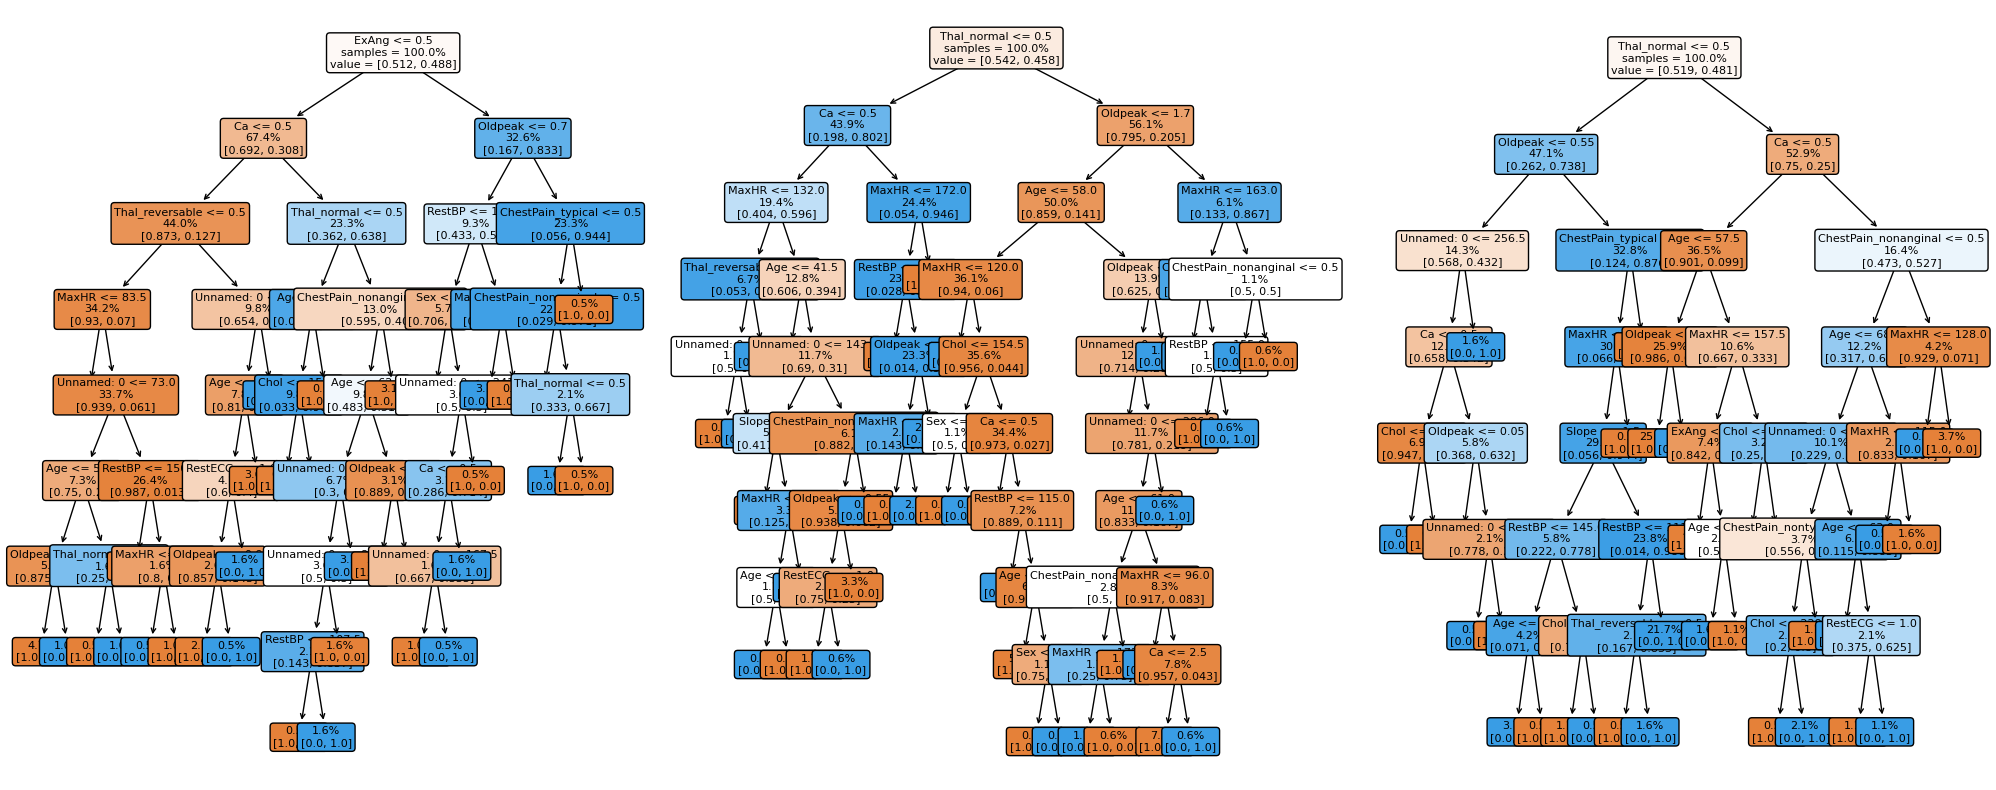

In [17]:
# An ensemble method that trains multiple base classifiers on random subsets of the training data and then aggregates their predictions to make the final prediction.
bagging = RandomForestClassifier(n_estimators = 200, max_features = None, random_state = 1)
# n_estimators: Number of trees in the forest.
# max_features: Maximum number of features to consider when splitting a node.
# random_state: Seed used by the random number generator. This ensures that the randomization used by the algorithm is reproducible.

bagging.fit(X,y) # Used to train the Bagging Classifier on the training data
fig, axs = plt.subplots(1,3,figsize = (25, 10))
for i, rf_tree in enumerate(bagging.estimators_[0:3]):
    plot_tree(rf_tree, feature_names = X_train.columns.tolist(), impurity = False, label = "root",
          filled = True, proportion = True, rounded = True, fontsize = 8, ax = axs[i])
# feature_names=X_train.columns.tolist(): Provides the names of the features (i.e., the independent variables) to use as labels for the nodes in the decision tree.
#  impurity = False: Specifies that we don't want to show the impurity (i.e., entropy or Gini index) for each node in the tree.
#   label = "root": Specifies that the root node should be labeled as "root".
#    filled = True: Specifies that we want to color the nodes in the tree based on the majority class of the training samples that fall within them.
#     proportion = True: Specifies that we want to show the proportion of training samples in each node that belong to each class.
#      rounded = True: Specifies that we want to round the corners of the boxes that represent nodes in the tree.
#       fontsize = 8: Specifies the font size to use for the text in the plot.
#        axs[i]: Plot each tree in a different subplot in the figure (axs).
plt.show() # Displays the plot of the decision tree.

#### 2.1) Tune the Forest

In [18]:
RFC = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 1, n_jobs = -2) # Fitting of each tree is independent
# n_estimators: Number of trees in the forest.
# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy of the model
# random_state: Seed used by the random number generator. This ensures that the randomization used by the algorithm is reproducible.
# n_jobs: The number of CPU cores to use for parallelizing the training and prediction processes. A value of -2 indicates that all but one CPU cores should be used.
RF.fit(X_train, y_train) # Trains the model on the training data and computes the decision boundary that separates different classes in the data

DecisionTreeClassifier(max_features='sqrt', random_state=946286476)

In [20]:
# Defaut "recommended" value for the hyper-parameter m
# (m=nb of variables randomly chosen to be considered at each split in each tree)
# We will search on a grid around it
default_max_features_param = np.sqrt(X_train.shape[1])  # Calculates the square root of the number of features in the training data, second element in the tuple
default_max_features_param

4.123105625617661

In [21]:
# Combination of features and leaves to give optimal tree result
hyperparam_grid = {"max_features":[3,4,5,6,7], # Most important, take trees that have largest variance to reduce just the variance while bias stays the same
                 'min_samples_leaf':[1,3,5,7,9,11]}

In [22]:
from sklearn.model_selection import ParameterGrid

rfc = RandomForestClassifier(n_estimators = 2000, oob_score = True,
                             warm_start = False, random_state = 1, n_jobs = -2)
# n_estimators: Number of trees in the forest.
# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy of the model
# random_state: Seed used by the random number generator. This ensures that the randomization used by the algorithm is reproducible.
# n_jobs: The number of CPU cores to use for parallelizing the training and prediction processes. A value of -2 indicates that all but one CPU cores should be used.
# warm_start: A Boolean value indicating whether to reuse the previously learned trees to fit the model further. If set to True, the model will reuse the previously learned trees and add more trees to the forest.

best_score = 0.5 # Baseline score (worse score with trees on average)

for g in ParameterGrid(hyperparam_grid): # dictionary
    rfc.set_params(**g)
    #or rfc.set_params(min_samples_leaf=g['min_samples_leaf'], max_features=g['max_features'])
    rfc.fit(X_train,y_train)
    # save if best
    if rfc.oob_score_ > best_score:
        best_score = rfc.oob_score_
        best_params = g

# The hyperparam_grid variable represents a dictionary of hyperparameters and their possible values to explore during the grid search. ParameterGrid() is a function from the scikit-learn library that takes the dictionary of hyperparameters and returns a generator that produces all possible combinations of hyperparameters to try.
# The rfc variable represents the Random Forest Classifier model that is being trained and evaluated during the grid search. The set_params() method is used to set the hyperparameters for each iteration of the grid search.
# The max_features hyperparameter is being set separately outside of the set_params() method call, which looks like a syntax error.
# rfc.fit(X_train,y_train) is training the RFC model with the current set of hyperparameters using the training data X_train and y_train.
# if rfc.oob_score_ > best_score: is checking if the current hyperparameters give a better out-of-bag (OOB) score than the current best score. The OOB score is a measure of the RFC model's accuracy using samples that were not used during training.
# best_score and best_params variables keep track of the best score achieved and the hyperparameters that produced that score, respectively, during the grid search.

print(f"OOB: {best_score:0.5f}")
print("Best parameters:", best_params)

OOB: 0.83544
Best parameters: {'max_features': 3, 'min_samples_leaf': 3}


#### 2.2) Model Diagnostic

In [23]:
rfc = RandomForestClassifier(n_estimators = 2000, max_features = best_params['max_features'],
                            min_samples_leaf = best_params['min_samples_leaf'],
                            oob_score = True, warm_start = False, random_state = 1, n_jobs = -2)
# n_estimators: Number of trees in the forest.
# max_features: Maximum number of features to consider when splitting a node.
# min_samples_leaf: Parameter specifies the minimum number of samples required to be at a leaf node. The value of best_params['min_samples_leaf'] is being passed as an argument here, which means that the best value of min_samples_leaf obtained during hyperparameter tuning is being used.
# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy of the model
# random_state: Seed used by the random number generator. This ensures that the randomization used by the algorithm is reproducible.
# n_jobs: The number of CPU cores to use for parallelizing the training and prediction processes. A value of -2 indicates that all but one CPU cores should be used.
# warm_start: A Boolean value indicating whether to reuse the previously learned trees to fit the model further. If set to True, the model will reuse the previously learned trees and add more trees to the forest.

rfc.fit(X_train, y_train) # Training the Random Forest Classifier model on the training data
y_hat = rfc.predict(X_test) # Using the trained model to predict the target labels for the test data
y_prob = rfc.predict_proba(X_test) # Using the trained model to predict the target labels for the test data X_test, but instead of predicting the actual label, it predicts the probability of each class.

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [25]:
rfc.oob_score_
# The OOB score is an estimate of the generalization performance of the model, which is calculated as the average accuracy of the model across all decision trees in the forest using the samples that were not included in the training of each decision tree.

0.8354430379746836

In [26]:
rfc.score(X_test,y_test) # Calculating the accuracy of the model's predictions by comparing them with the true target labels y_test.
# The score method is a convenience method in scikit-learn that returns the mean accuracy on the given test data and labels.

0.85

In [27]:
cm = confusion_matrix(y_test, y_hat) # Calculating the confusion matrix for the Random Forest Classifier model's predictions on the test data.
cm
# A confusion matrix is a table used to evaluate the performance of a classification model by comparing its predicted classes with the actual classes.

array([[27,  2],
       [ 7, 24]], dtype=int64)

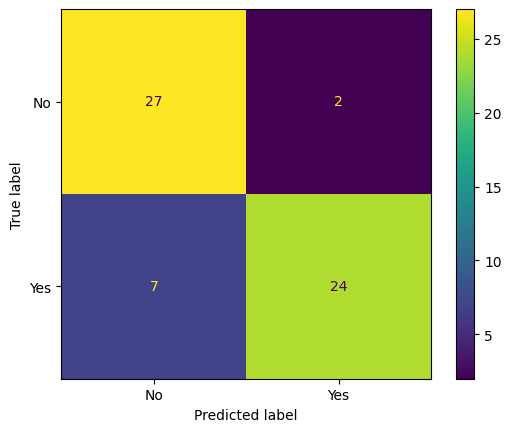

In [28]:
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rfc.classes_).plot()
# Parameter is set to the confusion matrix calculated in the previous step
# display_labels: Set to rfc.classes_, which is an array of the unique class labels in the target variable.

In [29]:
print(classification_report(y_test, y_hat, target_names = rfc.classes_))
# Using the classification_report function from scikit-learn's metrics module to generate a text report that includes various classification metrics for the Random Forest Classifier model's predictions on the test data.
# Classification_report function computes and displays several metrics for each class in the target variable, including precision, recall, and F1 score.

              precision    recall  f1-score   support

          No       0.79      0.93      0.86        29
         Yes       0.92      0.77      0.84        31

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

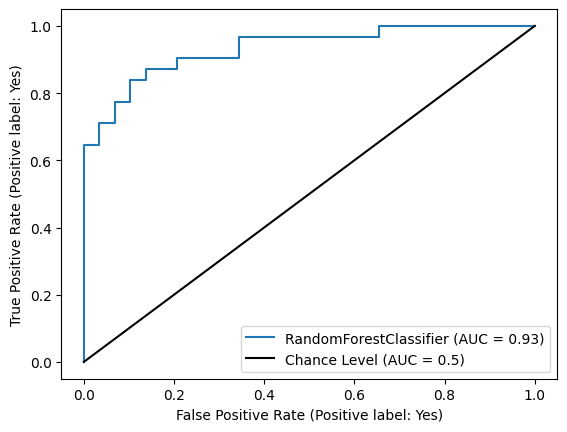

In [31]:
RocCurveDisplay.from_estimator(rfc, X_test ,y_test, pos_label = "Yes") # Using the RocCurveDisplay function from scikit-learn's metrics module to plot the receiver operating characteristic (ROC) curve for the Random Forest Classifier model's predictions on the test data.
plt.plot([0,1], [0,1], "k", label = "Chance Level (AUC = 0.5)") # Plotting a diagonal line on the ROC plot that represents the performance of a random classifier, where the true positive rate equals the false positive rate.
plt.legend() # Display the legend
plt.show() # Display the ROC curve plot,

In [32]:
roc_auc_score(y_test, y_prob[:,1]) # Using the roc_auc_score function from scikit-learn's metrics module to compute the area under the receiver operating characteristic curve (AUC-ROC) for the Random Forest Classifier model's predictions on the test data.

0.932146829810901